<a href="https://colab.research.google.com/github/DanchengLiu/device_classify/blob/main/LoRa_configuration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
'''
!wget --recursive --no-parent -R "index.html*" https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/Diff_Days_Indoor_Setup/Day1/Device1/
!wget --recursive --no-parent -R "index.html*" https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/Diff_Days_Indoor_Setup/Day1/Device2/
!wget --recursive --no-parent -R "index.html*" https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/Diff_Days_Indoor_Setup/Day2/Device1/
!wget --recursive --no-parent -R "index.html*" https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/Diff_Days_Indoor_Setup/Day2/Device2/
'''
for i in range(0,4):
  for j in range(0,25):
    cmd = 'wget --recursive --no-parent -R "index.html*" https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/Diff_Configurations_Setup/Config'+str(i+1)+'/IQ_'+str(j+1)+'.dat'
    os.system(cmd)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp -r /content/research.engr.oregonstate.edu /content/drive/MyDrive/configuration

In [4]:
!cp -r /content/drive/MyDrive/configuration/ /content/research.engr.oregonstate.edu

In [5]:
import matplotlib.pyplot as plt
import struct
import numpy as np

In [3]:

Xd_conf1 = bytes()
Xd_conf2 = bytes()
for i in range(1):
  Xf = open("/content/research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/Diff_Configurations_Setup/Config1/IQ_1.dat",'rb')
  Xd_conf1 = Xd_conf1+Xf.read()
  Xf.close()
for i in range(1):
  Xf = open("/content/research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/Diff_Configurations_Setup/Config2/IQ_1.dat",'rb')
  Xd_conf2 = Xd_conf2+Xf.read()
  Xf.close()

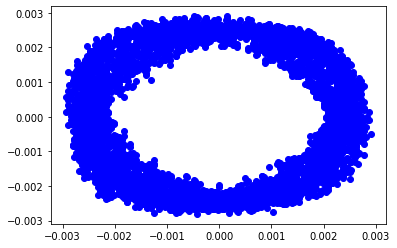

In [4]:
data = []
for i in range(len(Xd_conf1)//4):
  data.append(struct.unpack('f',Xd_conf1[i*4:i*4+4]))
data = np.array(data)
real = data[1:len(data)-1:2]
imag = data[2:len(data):2]
plt.plot(real[:5000], imag[:5000], 'bo')

X_psd1 = real[:5000]+1j*imag[:5000]


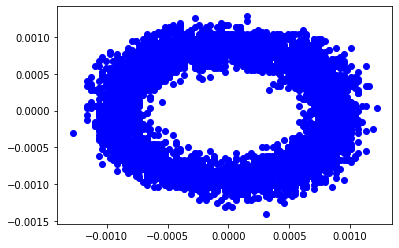

In [5]:
data = []
for i in range(len(Xd_conf2)//4):
  data.append(struct.unpack('f',Xd_conf2[i*4:i*4+4]))
data = np.array(data)
real = data[1:len(data)-1:2]
imag = data[2:len(data):2]
plt.plot(real[:5000], imag[:5000], 'bo')

X_psd2 = real[:5000]+1j*imag[:5000]

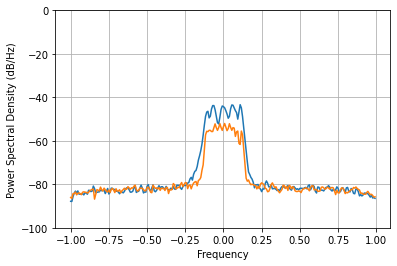

In [8]:
plt.ylim([-100, 0])
plt.psd(X_psd1[:,0])
plt.psd(X_psd2[:,0])
plt.show()

In [6]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [7]:
import struct
import numpy as np
import tensorflow_addons as tfa
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, SeparableConv2D, DepthwiseConv2D
from keras.layers import AveragePooling2D
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle, random
import sys, keras

In [9]:
temp = bytes()
data = []
for i in range(0,25):
  Xf = open("/content/research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/Diff_Configurations_Setup/Config1/IQ_"+str(i+1)+".dat",'rb')
  temp = Xf.read()
  # use only 1/10 data for now
  for j in range(len(temp)//4//10):
    data.append(struct.unpack('f',temp[j*4:j*4+4]))
  temp = bytes()
  Xf.close()



data = np.array(data)
print(data.shape)

(100000000, 1)


In [10]:
X = np.zeros((2, len(data)//2))

X[0,0:len(data)//2] = data[0:len(data)-1:2,0]
X[1,0:len(data)//2] = data[1:len(data):2,0]

X_reshape = np.reshape(X, (2,len(X[0])//8000,8000)).transpose((1,0,2))
print(X_reshape.shape)

(6250, 2, 8000)


In [11]:
Y = []
for i in range(0,25):
  for _ in range(250):
    Y.append(i+1)
Y = np.array(Y)
print(Y.shape)

(6250,)


In [12]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)])
    yy1[np.arange(len(yy)),yy-1] = 1
    return yy1

In [13]:
n_examples = 6250
n_train = int(0.8*6250)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))

# normalize
for i in range(len(X_reshape)):
  X_reshape[i] = X_reshape[i]/np.linalg.norm(X_reshape[i])

X_train = X_reshape[train_idx]
X_test =  X_reshape[test_idx]
Y_train = to_onehot(Y[train_idx])
Y_test =  to_onehot(Y[test_idx])

(8000,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0.]


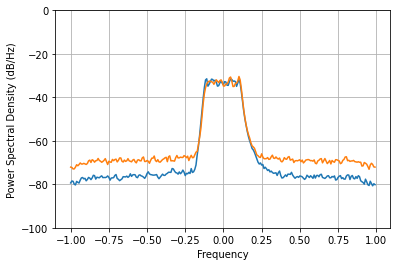

In [14]:
plt.ylim([-100, 0])

X = X_train[0][0]+1j*X_train[0][1]
print(X.shape)
plt.psd(X)
print(Y_train[0])

X = X_train[2][0]+1j*X_train[2][1]
plt.psd(X)
print(Y_train[2])
plt.show()

In [28]:
import os
from keras.layers import CuDNNLSTM
from keras.models import Model
from keras.layers import Input,Dense,Conv1D,Dropout,concatenate,Reshape, AveragePooling1D, AveragePooling2D, LeakyReLU, Flatten, BatchNormalization, MaxPooling2D, MaxPooling1D
from keras.layers.convolutional import Conv2D, SeparableConv2D, DepthwiseConv2D, DepthwiseConv1D

def CNN(weights=None,
             input_shape=[2,8000],
             classes=2,
             **kwargs):
    if weights is not None and not (os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), '
                         'or the path to the weights file to be loaded.')

    dr=0.5

    #input1=Input(input_shape+[1],name='To3D')

    input0=Input(input_shape+[1],name='Combined')
    


    # Part-A: Multi-channel Inputs and Spatial Characteristics Mapping Section
    x=Conv2D(16,(1,4),name="Conv1",kernel_initializer="glorot_uniform")(input0)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)
    x=MaxPooling2D(pool_size = (1,2), strides=(1,2))(x)

    x=Conv2D(24,(1,4),name="Conv2",kernel_initializer="glorot_uniform")(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)
    x=MaxPooling2D(pool_size = (1,2), strides=(1,2))(x)

    x=Conv2D(32,(1,4),name="Conv3",kernel_initializer="glorot_uniform")(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)
    x=MaxPooling2D(pool_size = (1,2), strides=(1,2))(x)

    x=Conv2D(48,(1,4),name="Conv4",kernel_initializer="glorot_uniform")(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)
    x=MaxPooling2D(pool_size = (1,2), strides=(1,2))(x)

    x=Conv2D(64,(1,4),name="Conv5",kernel_initializer="glorot_uniform")(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)
    x=MaxPooling2D(pool_size = (1,2), strides=(1,2))(x)

    x=Conv2D(96,(2,4),name="Conv6",kernel_initializer="glorot_uniform")(x)
    x=BatchNormalization()(x)
    x=LeakyReLU()(x)
    x=AveragePooling2D(pool_size = (1,244))(x)

    #DNN
    x=Flatten()(x)
    x=Dense(25,name="FC1")(x)
    x=LeakyReLU()(x)
    x=Dropout(dr)(x)

    
    x=Dense(classes,activation="softmax",name="Softmax")(x)

    model=Model(inputs=input0,outputs=x)

    # Load weights.
    if weights is not None:
        model.load_weights(weights)
    
    return model

In [29]:
model = CNN(classes=25)
model.compile(loss='categorical_crossentropy', optimizer=tfa.optimizers.SGDW(weight_decay = 0.0001, learning_rate=0.07))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Combined (InputLayer)       [(None, 2, 8000, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 2, 7997, 16)       80        
                                                                 
 batch_normalization_36 (Bat  (None, 2, 7997, 16)      64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 2, 7997, 16)       0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 2, 3998, 16)      0         
 g2D)                                                            
                                                                 
 Conv2 (Conv2D)              (None, 2, 3995, 24)       1560

In [30]:
batch_size=100
nb_epoch=100
filepath = 'CNN.h5'
with tf.device('/device:GPU:0'):
    history = model.fit(X_train,
        Y_train,
        batch_size=batch_size,
        epochs=nb_epoch,
        verbose=2,
        validation_data=(X_test, Y_test),
        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
        ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
50/50 - 102s - loss: 3.2321 - val_loss: 3.2323 - 102s/epoch - 2s/step
Epoch 2/100
50/50 - 102s - loss: 3.1532 - val_loss: 3.2694 - 102s/epoch - 2s/step
Epoch 3/100
50/50 - 102s - loss: 2.9924 - val_loss: 4.5144 - 102s/epoch - 2s/step
Epoch 4/100
50/50 - 106s - loss: 2.8290 - val_loss: 7.9372 - 106s/epoch - 2s/step
Epoch 5/100
50/50 - 102s - loss: 2.7126 - val_loss: 11.1081 - 102s/epoch - 2s/step
Epoch 6/100
50/50 - 102s - loss: 2.6054 - val_loss: 16.6533 - 102s/epoch - 2s/step
Epoch 7/100
50/50 - 101s - loss: 2.4946 - val_loss: 18.6944 - 101s/epoch - 2s/step
Epoch 8/100
50/50 - 102s - loss: 2.4352 - val_loss: 14.7664 - 102s/epoch - 2s/step
Epoch 9/100
50/50 - 101s - loss: 2.3810 - val_loss: 46.5165 - 101s/epoch - 2s/step
Epoch 10/100
50/50 - 100s - loss: 2.3297 - val_loss: 355.6519 - 100s/epoch - 2s/step
Epoch 11/100
50/50 - 101s - loss: 2.2988 - val_loss: 22.3676 - 101s/epoch - 2s/step
Epoch 12/100
50/50 - 101s - loss: 2.2048 - val_loss: 28.9560 - 101s/epoch - 2s/step
Epoc

In [31]:
pred = model.predict(X_test)

40/40 [==============================] - 9s 216ms/step


In [32]:
acc = 0
for i in range(len(Y_test)):
  if np.argmax(Y_test[i])==np.argmax(pred[i]):
    acc+=1
print(acc/(len(Y_test)))


0.0336


(8000,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0.]


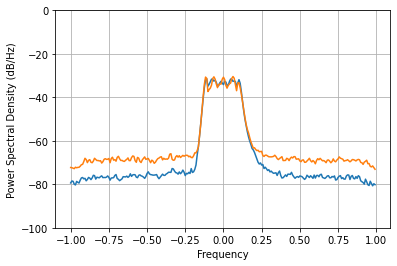

In [34]:
plt.ylim([-100, 0])

X = X_train[0][0]+1j*X_train[0][1]
print(X.shape)
plt.psd(X)
print(Y_train[0])

X = X_train[1][0]+1j*X_train[1][1]
plt.psd(X)
print(Y_train[1])
plt.show()